<a href="https://colab.research.google.com/github/dewimustikaa/Kekeringan-Meteorologi/blob/main/Kekeringan_Meteorologi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Membuat SPI dan Mendapatkan Landsat-8 data serta DEM Slope

* Pada part ini kita akan menggunakan GEEMap library. Kita akan mendapatkan data bulanan SPI serta Landsat-8.
* Kita akan memprosed data Landsat-8 termasuk perhitungan spectral index dan temperature.
* langkah selanjutnya adalah menambahkan DEM slope sebagai feature tambahan.

**Note:** Kita akan membuat satu function untuk memproses semua ini untuk efektivitas

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Import Library yang dibutuhkan
import ee
import geemap

In [ ]:
# additional library
!pip install pycrs

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=0d812fa9742e9f934ade63b5147f6e28c6ed2c048760624a0dd3d9936d2de50d
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Successfully built pycrs


In [ ]:
# Melakukan autentikasi dan mendefinisikan Google Cloud Project yang akan digunakan
ee.Authenticate()
ee.Initialize(project='ee-khafidz') #ganti dengan nama Google Cloud Project anda

In [ ]:
# Menambahkan basemap
m = geemap.Map()
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Memasukkan shapefile AOI dan mengubahnya kedalam earth engine object
AOI_ee = geemap.shp_to_ee("/content/drive/MyDrive/Mustika/Batas Admin Indramayu/Batas Admin/Admin_IM.shp")
AOI_ee = AOI_ee.geometry()

In [ ]:
# Menambahkan AOI Kedalam Peta GEEMAP
m.addLayer(AOI_ee, {}, "AOI Geosfotware")
m.centerObject(AOI_ee, 10) #Set zoom in
m

Map(center=[-6.44859813025093, 108.16879158361478], controls=(WidgetControl(options=['position', 'transparent_…

### Pembuatan Function Preprocessing Data
Kita akan membuat function besar untuk memproses semua data termasuk SPI, Landsat-8 dan DEM, sehingga kita akan secara efektif mendapatkan data bulanan tersebut.


problem : coding perhitungan lst dan smi masih belum sesuai hasilnya

In [ ]:
import ee

def Combined_Monthly(start_month, end_month, year, AOI):
    S2_Col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    L8_Col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

    def mask_s2_clouds(image):
        qa = image.select('QA60')
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11
        mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
            qa.bitwiseAnd(cirrus_bit_mask).eq(0)
        )
        return image.updateMask(mask).divide(10000)

    def applyScaleFactors(image):
        opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
        thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
        return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

    def L8cloudMask(image):
        cloudShadowBitmask = (1 << 3)
        cloudBitmask = (1 << 5)
        qa = image.select('QA_PIXEL')
        mask = qa.bitwiseAnd(cloudShadowBitmask).eq(0).And(qa.bitwiseAnd(cloudBitmask).eq(0))
        return image.updateMask(mask)

    def addNDVI(image):
        ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    def addNDWI(image):
        ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
        return image.addBands(ndwi)

    def resample_and_combine(S2_composite, L8_LST, SMI, target_scale=10):
        LST_resampled = L8_LST.reproject(
            crs=S2_composite.projection(),
            scale=target_scale
        )
        SMI_resampled = SMI.reproject(
            crs=S2_composite.projection(),
            scale=target_scale
        )
        return S2_composite.addBands(LST_resampled).addBands(SMI_resampled)

    monthly_data = {}

    for month in range(start_month, end_month + 1):
        try:
            start_date = f"{year}-{month:02d}-01"
            end_date = f"{year}-{month + 1:02d}-01" if month < 12 else f"{year + 1}-01-01"

            # Sentinel-2 cloud masking, NDVI, NDWI
            S2_filtered = S2_Col.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25))\
                .filter(ee.Filter.date(start_date, end_date))\
                .filter(ee.Filter.bounds(AOI))\
                .map(mask_s2_clouds)\
                .map(addNDVI)\
                .map(addNDWI)\
                .select('B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12', 'NDVI', 'NDWI')

            S2_medianComposite = S2_filtered.median().clip(AOI)

            # Process Landsat-8 data
            L8_filtered = L8_Col.filter(ee.Filter.date(start_date, end_date))\
                .filter(ee.Filter.bounds(AOI))\
                .map(applyScaleFactors)\
                .map(L8cloudMask)

            # Check if Landsat-8 data is available
            if L8_filtered.size().getInfo() > 0:
                # Create median composite and clip to area
                L8_medianComposite = L8_filtered.median().clip(AOI)

                # Calculate LST and TCI
                L8_STB10 = L8_medianComposite.select('ST_B10')

                # Calculate LST in Celsius
                L8_LST_Cel = L8_STB10.expression('STB10 - 273.15', {
                    'STB10': L8_STB10.select('ST_B10')
                }).rename('LST')

                # NDVI max and min
                maxNDVI = ee.Number(S2_medianComposite.select('NDVI').reduceRegion(ee.Reducer.max(), AOI, 30).get('NDVI'))
                minNDVI = ee.Number(S2_medianComposite.select('NDVI').reduceRegion(ee.Reducer.min(), AOI, 30).get('NDVI'))

                # Calculate Fractional Vegetation (FV) from NDVI
                FV = S2_medianComposite.select('NDVI').subtract(minNDVI).divide(maxNDVI.subtract(minNDVI)).pow(ee.Number(2)).rename('FV')

                # Emissivity (E)
                E = FV.multiply(0.004).add(0.986).rename('E')

                # Normalization of NDVI and LST
                ndvi = S2_medianComposite.select('NDVI')
                ndvi_min = ee.Number(ndvi.reduceRegion(ee.Reducer.min(), AOI, 30).get("NDVI"))
                ndvi_max = ee.Number(ndvi.reduceRegion(ee.Reducer.max(), AOI, 30).get("NDVI"))
                lst_min = ee.Number(L8_LST_Cel.reduceRegion(ee.Reducer.min(), AOI, 30).get("LST"))
                lst_max = ee.Number(L8_LST_Cel.reduceRegion(ee.Reducer.max(), AOI, 30).get("LST"))

                ndvi_norm = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min))
                lst_norm = L8_LST_Cel.subtract(lst_min).divide(lst_max.subtract(lst_min))

                # Soil Moisture Index (SMI)
                SMI = ee.Image(1).subtract(lst_norm).multiply(ndvi_norm).rename("SMI")
            else:
                print(f"Warning: No Landsat-8 data available for month {month}")
                L8_LST_Cel = ee.Image.constant(0).rename('LST')
                SMI = ee.Image.constant(0).rename('SMI')

            # SRTM elevation data
            dataset_SRTM = ee.Image("USGS/SRTMGL1_003")
            elevation = dataset_SRTM.select('elevation').clip(AOI)
            slope = ee.Terrain.slope(elevation).rename('slope').clip(AOI)

            # Resampling and combining with Sentinel-2 composite
            resampled_thermal = resample_and_combine(S2_medianComposite, L8_LST_Cel, SMI)

            final_composite = resampled_thermal\
                .addBands(elevation)\
                .addBands(slope)\
                .float()

            monthly_data[month] = final_composite

        except Exception as e:
            print(f"Error processing month {month}: {str(e)}")
            continue

    return monthly_data


In [ ]:
# Menerapkan fungsi S2_monthly untuk mendapatkan data citra sentinel-2 bulanan
monthly_images = Combined_Monthly(start_month=7, end_month=10, year=2023, AOI=AOI_ee)

juli_image = monthly_images[7] # Extract data S2 bulan juli
agustus_image = monthly_images[8] # Extract data S2 bulan Agustus
september_image = monthly_images[9] # Extract data S2 bulan September
oktober_image = monthly_images[10] # Extract data S2 bulan Oktober

In [ ]:
agustus_image

In [ ]:
print(juli_image.bandNames().getInfo())  # Check the available band names for July
print(agustus_image.bandNames().getInfo())  # Check the available band names for August
print(september_image.bandNames().getInfo())  # Check the available band names for September
print(oktober_image.bandNames().getInfo())  # Check the available band names for October


['B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope']
['B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope']
['B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope']
['B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope']


In [ ]:
# Visualisasi citra Sentinel-2 setiap bulan

m.addLayer(juli_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Juli Composite')
m.addLayer(agustus_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Agustus Composite')
m.addLayer(september_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'September Composite')
m.addLayer(oktober_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Oktober Composite')
m

Map(bottom=136078.0, center=[-6.44859813025093, 108.16879158361478], controls=(WidgetControl(options=['positio…

In [ ]:
# Download S2 data setiap bulan ke Google Drive kita
# Export dengan default WGS84 tanpa mendefinisikan CRS
geemap.ee_export_image_to_drive(juli_image, description="S2_Juli_2024", folder="Kekeringan_Update", region=AOI_ee, scale=10)

In [ ]:
geemap.ee_export_image_to_drive(agustus_image, description="S2_Agustus_2024", folder="Kekeringan_Update", region=AOI_ee, scale=10)

In [ ]:
geemap.ee_export_image_to_drive(september_image, description="S2_September_2024", folder="Kekeringan_Update", region=AOI_ee, scale=10)

In [ ]:
geemap.ee_export_image_to_drive(oktober_image, description="S2_Oktober_2024", folder="Kekeringan_Update", region=AOI_ee, scale=10)

Untuk melihat perkembangan export ke google drive. Kita bisa menggunakan Link:
https://code.earthengine.google.com/tasks

Setelah berhasil ke export, kita bisa mengunduh data.tif tersebut dan memakainya sesuai kebutuhan kita.

## Preprocessing data shapefile SPI untuk target data

In [ ]:
# install Library rasterio
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 109.8 MB/s eta 0:00:00


In [ ]:
# Import Library yang dibutuhkan
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [ ]:
import geopandas as gpd

# Memasukkan shapefile
shp_path = '/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/NEW DATA SPI/NEW_Data_2024.shp'
gdf = gpd.read_file(shp_path)
gdf.head()

,FID_,X,Y,Stasiun,Tahun,Bulan,CurahHujan,Kategori_S,SPI3,SPI2,geometry
0,0,107.958767,-6.376123,arx,2024,10,0,Extreme Dry,-0.267460,-2.267460,POINT (107.95877 -6.37612)
1,3,108.291800,-6.514650,arx,2024,10,1,Extreme Dry,-2.132127,-2.132127,POINT (108.2918 -6.51465)
2,4,108.034561,-6.377950,arx,2024,10,0,Extreme Dry,-2.947629,-2.947629,POINT (108.03456 -6.37795)
3,6,108.210049,-6.518020,arx,2024,10,0,Extreme Dry,-2.696503,-2.696503,POINT (108.21005 -6.51802)
4,7,108.077790,-6.440240,arx,2024,10,0,Extreme Dry,-2.912646,-2.912646,POINT (108.07779 -6.44024)


In [ ]:
# Mendefinisikan target bulan yang akanb diekstrak
months = {7: "SPI2_Juli", 8: "SPI2_Agustus", 9: "SPI2_September", 10: "SPI2_Oktober"}
filtered_gdf = gdf[(gdf['Tahun'] == 2024) & (gdf['Bulan'].isin(months.keys()))]

# Membuat unique statiun ID
unique_stations = filtered_gdf[['Stasiun']].drop_duplicates().reset_index(drop=True)
unique_stations['Stasiun_ID'] = range(1, len(unique_stations) + 1)

# Membuat function untuk extract shapefile setiap bulan
def extract_spi_data(month_num, month_name):
    month_data = filtered_gdf[filtered_gdf['Bulan'] == month_num][['X', 'Y', 'Stasiun', 'SPI2', 'geometry']]
    month_data = month_data.reset_index(drop=True)
    # month_data = month_data.rename(columns={'SPI2': month_name}).reset_index(drop=True)

    # Merge dengan stasiun ID
    month_data = month_data.merge(unique_stations, on='Stasiun', how='left')

    return month_data

In [ ]:
# menerapkan function yang telah dibuat
SPI2_Juli = extract_spi_data(7, "SPI2_Juli")
SPI2_Agustus = extract_spi_data(8, "SPI2_Agustus")
SPI2_September = extract_spi_data(9, "SPI2_September")
SPI2_Oktober = extract_spi_data(10, "SPI2_Oktober")

In [ ]:
print(SPI2_Juli.shape, SPI2_Agustus.shape, SPI2_September.shape, SPI2_Oktober.shape)

(232, 6) (232, 6) (232, 6) (232, 6)


In [ ]:
SPI2_Juli.head()

,X,Y,Stasiun,SPI2,geometry,Stasiun_ID
0,107.958767,-6.376123,arx,-2.260953,POINT (107.95877 -6.37612),1
1,108.034561,-6.377950,arx,-2.974363,POINT (108.03456 -6.37795),1
2,108.077790,-6.440240,arx,-2.937449,POINT (108.07779 -6.44024),1
3,107.951112,-6.589091,arx,-2.334841,POINT (107.95111 -6.58909),1
4,107.943378,-6.460257,arx,-2.349900,POINT (107.94338 -6.46026),1


In [ ]:
SPI2_Agustus.head()

,X,Y,Stasiun,SPI2,geometry,Stasiun_ID
0,107.965017,-6.568139,arx,-2.371737,POINT (107.96502 -6.56814),1
1,107.960268,-6.403667,arx,-2.071151,POINT (107.96027 -6.40367),1
2,107.917246,-6.406278,arx,-2.416364,POINT (107.91725 -6.40628),1
3,107.930050,-6.501720,arx,-2.303254,POINT (107.93005 -6.50172),1
4,107.991089,-6.484878,arx,-2.221669,POINT (107.99109 -6.48488),1


In [ ]:
SPI2_September.head()

,X,Y,Stasiun,SPI2,geometry,Stasiun_ID
0,107.958767,-6.376123,arx,-2.250138,POINT (107.95877 -6.37612),1
1,108.371773,-6.358935,arx,-2.192829,POINT (108.37177 -6.35893),1
2,108.291800,-6.514650,arx,-2.132127,POINT (108.2918 -6.51465),1
3,108.034561,-6.377950,arx,-2.947629,POINT (108.03456 -6.37795),1
4,108.077790,-6.440240,arx,-2.912646,POINT (108.07779 -6.44024),1


In [ ]:
SPI2_Oktober.head()

,X,Y,Stasiun,SPI2,geometry,Stasiun_ID
0,107.958767,-6.376123,arx,-2.267460,POINT (107.95877 -6.37612),1
1,108.291800,-6.514650,arx,-2.132127,POINT (108.2918 -6.51465),1
2,108.034561,-6.377950,arx,-2.947629,POINT (108.03456 -6.37795),1
3,108.210049,-6.518020,arx,-2.696503,POINT (108.21005 -6.51802),1
4,108.077790,-6.440240,arx,-2.912646,POINT (108.07779 -6.44024),1


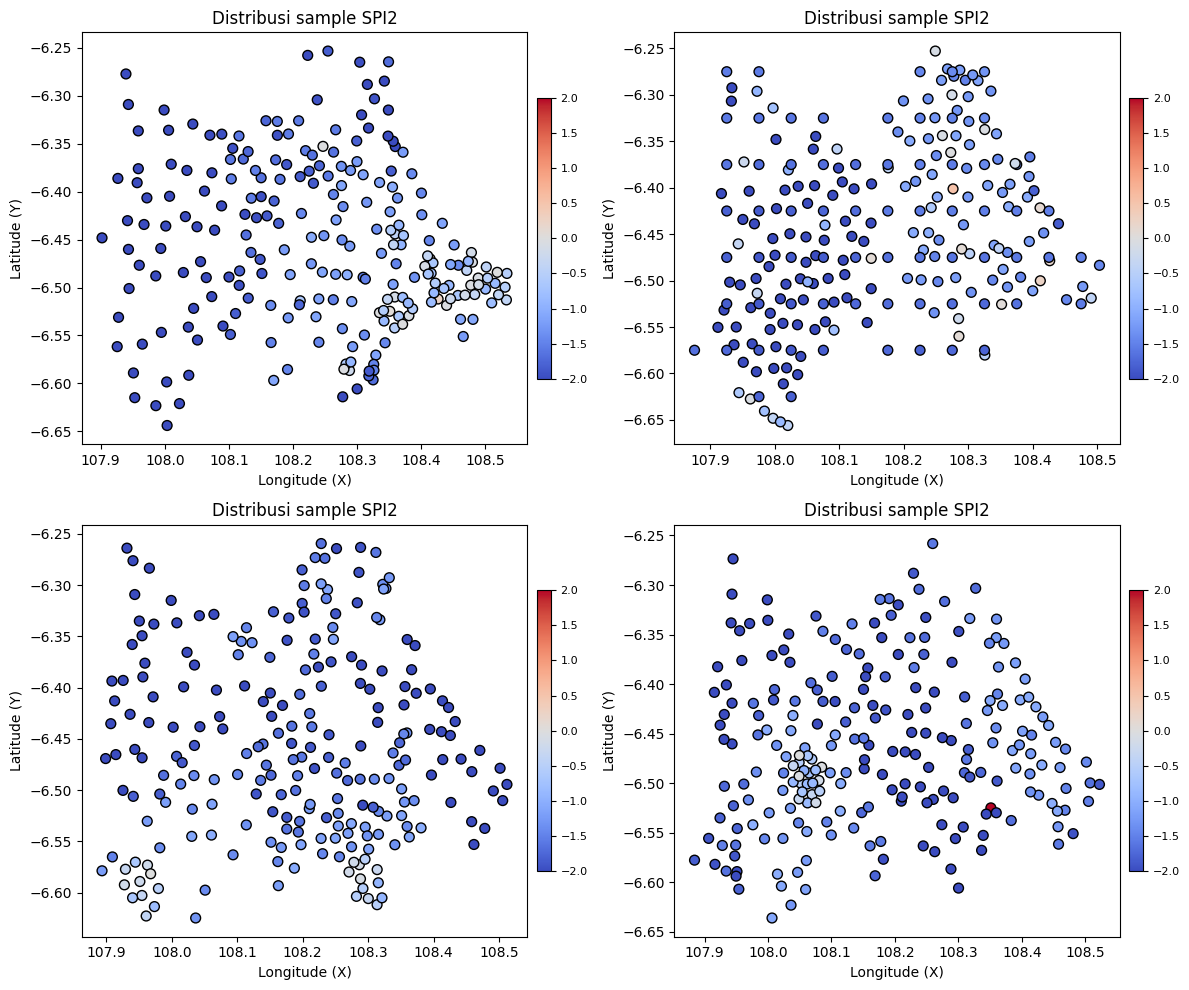

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Pastikan data tidak mengandung NaN
SPI2_Juli = SPI2_Juli.dropna()
SPI2_Agustus = SPI2_Agustus.dropna()
SPI2_September = SPI2_September.dropna()
SPI2_Oktober = SPI2_Oktober.dropna()

# Membuat subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Mendefinisikan data yang akan diplot
datasets = [(SPI2_Juli, 'SPI2'), (SPI2_Agustus, 'SPI2'),
            (SPI2_September, 'SPI2'), (SPI2_Oktober, 'SPI2')]

# Mendefinisikan color
cmap = 'coolwarm'
norm = mcolors.Normalize(vmin=-2, vmax=2)

# Plot setiap dataset
for ax, (data, title) in zip(axes.flat, datasets):
    data.plot(ax=ax, column=title, cmap=cmap, norm=norm, legend=False, markersize=50, edgecolor='black')
    ax.set_title(f"Distribusi sample {title}", fontsize=12)
    ax.set_xlabel("Longitude (X)")
    ax.set_ylabel("Latitude (Y)")

    # Atur aspect ratio
    ax.set_aspect('auto')

    # Shrink and position the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# Menyimpan GeoDataFrame sebagai data shapefiles
SPI2_Juli.to_file('/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/2spispi_Juli.shp')
SPI2_Agustus.to_file('/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/2spispi_Agustus.shp')
SPI2_September.to_file('/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/2spispi_September.shp')
SPI2_Oktober.to_file('/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/2spispi_Oktober.shp')

## Menambahkan data lain (curah hujan bulanan) kedalam data L8 yang sudah dibuat sebelumnya

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.7 MB/s eta 0:00:00


In [ ]:
# import AOi kita menggunakan geopandas
import geopandas as gpd

AOI = gpd.read_file('/content/drive/MyDrive/Mustika/Batas Admin Indramayu/Batas Admin/Admin_IM.shp')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import rasterio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import numpy as np

# def stack_band_tambahan(original_path, additional_path):

#     # Membuka data original (dalam contoh ini 16 bands)
#     with rasterio.open(original_path) as src:
#         original_data = src.read()  # (Bands, H, W)
#         transform = src.transform
#         crs = src.crs
#         meta = src.meta
#         desc = src.descriptions
#         width, height = src.width, src.height

#     # Convert ke (H, W, Bands) format
#     original_data = original_data.transpose(1, 2, 0)

#     # membuka data tambahan yang ingin distack
#     with rasterio.open(additional_path) as add_src:
#         additional_data = add_src.read()  # (Bands, H, W)
#         add_transform = add_src.transform
#         add_crs = add_src.crs
#         add_bands = additional_data.shape[0]  # number of band

#         # Reproject data tambahan apabila sistem proyeksinya tidak sama dengan data asli
#         if add_crs != crs:
#             transform, width, height = calculate_default_transform(
#                 add_crs, crs, add_src.width, add_src.height, *add_src.bounds
#             )
#             additional_reprojected = np.empty((add_bands, height, width), dtype=additional_data.dtype)

#             for i in range(add_bands):
#                 reproject(
#                     source=additional_data[i],
#                     destination=additional_reprojected[i],
#                     src_transform=add_transform,
#                     src_crs=add_crs,
#                     dst_transform=transform,
#                     dst_crs=crs,
#                     resampling=Resampling.bilinear
#                 )
#         else:
#             additional_reprojected = additional_data

#         # Resample data tambahan supaya memiliki resolusi yang sama dengan data original
#         additional_resampled = np.empty((add_bands, original_data.shape[0], original_data.shape[1]), dtype=additional_data.dtype)

#         for i in range(add_bands):
#             reproject(
#                 source=additional_reprojected[i],
#                 destination=additional_resampled[i],
#                 src_transform=add_transform,
#                 src_crs=crs,
#                 dst_transform=transform,
#                 dst_crs=crs,
#                 dst_width=original_data.shape[1],
#                 dst_height=original_data.shape[0],
#                 resampling=Resampling.bilinear # disini resampling menggunakan bilinear
#             )

#     # convert hasil resampling band tambahan kedalam format H,W,C
#     additional_resampled = additional_resampled.transpose(1, 2, 0)

#     # Langkah terakhir adalah stacking
#     stacked_array = np.dstack([original_data, additional_resampled])

#     return stacked_array, meta, desc, transform

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

def stack_bands(original_path, additional_paths):
    """
    Menggabungkan (stacking) data raster asli dengan beberapa data tambahan.

    Parameters:
        original_path (str): Path ke file GeoTIFF asli.
        additional_paths (list): List berisi path ke file GeoTIFF tambahan.

    Returns:
        stacked_array (np.ndarray): Array hasil stacking dengan bentuk (H, W, Bands).
        meta (dict): Metadata dari data asli.
        desc (tuple): Deskripsi band dari data asli.
        transform (Affine): Transformasi affine dari data asli.
    """
    # Membuka data original
    with rasterio.open(original_path) as src:
        original_data = src.read()  # (Bands, H, W)
        transform = src.transform
        crs = src.crs
        meta = src.meta
        desc = src.descriptions
        width, height = src.width, src.height

    # Convert ke format (H, W, Bands)
    original_data = original_data.transpose(1, 2, 0)

    # Inisialisasi list untuk menyimpan data tambahan yang sudah diproses
    additional_stacked = []

    # Loop melalui setiap path tambahan
    for additional_path in additional_paths:
        with rasterio.open(additional_path) as add_src:
            additional_data = add_src.read()  # (Bands, H, W)
            add_transform = add_src.transform
            add_crs = add_src.crs
            add_bands = additional_data.shape[0]  # Jumlah band dalam data tambahan

            # Reproject data tambahan jika CRS-nya berbeda dengan data asli
            if add_crs != crs:
                transform, width, height = calculate_default_transform(
                    add_crs, crs, add_src.width, add_src.height, *add_src.bounds
                )
                additional_reprojected = np.empty((add_bands, height, width), dtype=additional_data.dtype)

                for i in range(add_bands):
                    reproject(
                        source=additional_data[i],
                        destination=additional_reprojected[i],
                        src_transform=add_transform,
                        src_crs=add_crs,
                        dst_transform=transform,
                        dst_crs=crs,
                        resampling=Resampling.bilinear
                    )
            else:
                # Jika CRS sama, gunakan data tambahan tanpa reprojection
                additional_reprojected = additional_data

            # Resample data tambahan agar sesuai dengan resolusi data asli
            additional_resampled = np.empty((add_bands, original_data.shape[0], original_data.shape[1]), dtype=additional_data.dtype)

            for i in range(add_bands):
                reproject(
                    source=additional_reprojected[i],
                    destination=additional_resampled[i],
                    src_transform=transform if add_crs == crs else transform,
                    src_crs=crs,
                    dst_transform=src.transform,
                    dst_crs=crs,
                    dst_width=original_data.shape[1],
                    dst_height=original_data.shape[0],
                    resampling=Resampling.bilinear
                )

            # Convert hasil resampling ke format (H, W, Bands)
            additional_resampled = additional_resampled.transpose(1, 2, 0)

            # Tambahkan ke list additional_stacked
            additional_stacked.append(additional_resampled)

    # Gabungkan semua data tambahan dengan data asli
    stacked_array = np.dstack([original_data] + additional_stacked)

    return stacked_array, meta, desc, transform



In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

def reproject_and_resample(src_array, src_transform, src_crs, dst_transform, dst_crs, dst_shape, resampling=Resampling.bilinear):
    """
    Melakukan reprojection dan resampling array raster agar sesuai dengan data referensi.
    """
    bands, dst_height, dst_width = src_array.shape[0], dst_shape[0], dst_shape[1]
    result = np.empty((bands, dst_height, dst_width), dtype=src_array.dtype)

    for i in range(bands):
        reproject(
            source=src_array[i],
            destination=result[i],
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            dst_width=dst_width,
            dst_height=dst_height,
            resampling=resampling
        )
    return result

def stack_bands(original_path, additional_paths):
    """
    Menggabungkan data raster utama dengan data tambahan menjadi satu array stack.
    """
    with rasterio.open(original_path) as src:
        original_data = src.read()  # (Bands, H, W)
        original_transform = src.transform
        original_crs = src.crs
        original_shape = (src.height, src.width)
        meta = src.meta
        desc = src.descriptions

    original_data = original_data.transpose(1, 2, 0)  # (H, W, Bands)
    stacked_list = [original_data]

    for path in additional_paths:
        with rasterio.open(path) as add_src:
            add_data = add_src.read()  # (Bands, H, W)
            add_transform = add_src.transform
            add_crs = add_src.crs

            # Jika CRS berbeda, reproject dan resample
            if add_crs != original_crs:
                dst_transform, dst_width, dst_height = calculate_default_transform(
                    add_crs, original_crs, add_src.width, add_src.height, *add_src.bounds
                )
                reprojected = reproject_and_resample(
                    src_array=add_data,
                    src_transform=add_transform,
                    src_crs=add_crs,
                    dst_transform=original_transform,
                    dst_crs=original_crs,
                    dst_shape=original_shape
                )
            else:
                # Jika CRS sama, cukup resample ke ukuran referensi
                reprojected = reproject_and_resample(
                    src_array=add_data,
                    src_transform=add_transform,
                    src_crs=add_crs,
                    dst_transform=original_transform,
                    dst_crs=original_crs,
                    dst_shape=original_shape
                )

            reprojected = reprojected.transpose(1, 2, 0)  # (H, W, Bands)
            stacked_list.append(reprojected)

    stacked_array = np.dstack(stacked_list)
    return stacked_array, meta, desc, original_transform


In [ ]:
# Contoh penggunaan fungsi
S2_juli, S2_meta, desc, transform = stack_bands(
    original_path="/content/drive/MyDrive/Mustika/Kekeringan_Update/S2_Juli_2024.tif",  # Path data asli
    additional_paths=[
         "/content/drive/MyDrive/Mustika/Faktor Fisik/Jenis Tanah.tif",  # Path data tambahan 1
         "/content/drive/MyDrive/Mustika/Faktor Fisik/Landcover.tif",    # Path data tambahan 2
         "/content/drive/MyDrive/Mustika/Faktor Fisik/TWI.tif",          # Path data tambahan 3
         "/content/drive/MyDrive/Mustika/Faktor Fisik/DATA CH/ch juli.tif"
    ]
)

# Cetak bentuk array hasil stacking
print("Shape of stacked array:", S2_juli.shape)

Shape of stacked array: (4824, 7677, 17)


In [ ]:
# Menerapkan fungsi yang telah dibuat untuk bulan agustus
S2_agustus, S2_meta, desc, transform = stack_bands(
    original_path="/content/drive/MyDrive/Mustika/Kekeringan_Update/S2_Agustus_2024.tif",  # Path data asli
    additional_paths=[
        "/content/drive/MyDrive/Mustika/Faktor Fisik/Jenis Tanah.tif",     # Path data tambahan 1
        "/content/drive/MyDrive/Mustika/Faktor Fisik/Landcover.tif",       # Path data tambahan 2
        "/content/drive/MyDrive/Mustika/Faktor Fisik/TWI.tif",             # Path data tambahan 3
        "/content/drive/MyDrive/Mustika/Faktor Fisik/DATA CH/ch agustus2.tif"   # Path data tambahan 4
    ]
)

# Cetak bentuk array hasil stacking
print("Shape of stacked array:", S2_agustus.shape)

Shape of stacked array: (4824, 7677, 17)


In [ ]:
# Menerapkan fungsi yang telah dibuat untuk bulan september
S2_september, S2_meta, desc, transform = stack_bands(
    original_path="/content/drive/MyDrive/Mustika/Kekeringan_Update/S2_September_2024.tif",  # Path data asli
    additional_paths=[
      "/content/drive/MyDrive/Mustika/Faktor Fisik/Jenis Tanah.tif",      # Path data tambahan 1
      "/content/drive/MyDrive/Mustika/Faktor Fisik/Landcover.tif",        # Path data tambahan 2
      "/content/drive/MyDrive/Mustika/Faktor Fisik/TWI.tif",              # Path data tambahan 3
      "/content/drive/MyDrive/Mustika/Faktor Fisik/DATA CH/ch september.tif"  # Path data tambahan 4
    ]
)

# Cetak bentuk array hasil stacking
print("Shape of stacked array:", S2_september.shape)

Shape of stacked array: (4824, 7677, 17)


In [ ]:
# Menerapkan fungsi yang telah dibuat untuk bulan oktober
S2_oktober, S2_meta, desc, transform = stack_bands(
    original_path="/content/drive/MyDrive/Mustika/Kekeringan_Update/S2_Oktober_2024.tif",  # Path data asli
    additional_paths=[
        "/content/drive/MyDrive/Mustika/Faktor Fisik/Jenis Tanah.tif",  # Path data tambahan 1
        "/content/drive/MyDrive/Mustika/Faktor Fisik/Landcover.tif",        # Path data tambahan 2
        "/content/drive/MyDrive/Mustika/Faktor Fisik/TWI.tif",         # Path data tambahan 3
        "/content/drive/MyDrive/Mustika/Faktor Fisik/DATA CH/ch oktober.tif"
    ]
)

# Cetak bentuk array hasil stacking
print("Shape of stacked array:", S2_oktober.shape)

Shape of stacked array: (4824, 7677, 17)


In [ ]:
# Check shape of output
print(S2_juli.shape)
print(S2_agustus.shape)
print(S2_september.shape)
print(S2_september.shape)

(4824, 7677, 17)
(4824, 7677, 17)
(4824, 7677, 17)
(4824, 7677, 17)


In [ ]:
# Perbarui metadata untuk S2_juli
S2_meta.update({
    "count": S2_juli.shape[2],  # Jumlah band setelah stacking
    "dtype": S2_juli.dtype      # Tipe data array
})

# Perbarui metadata untuk S2_agustus
S2_meta.update({
    "count": S2_agustus.shape[2],  # Jumlah band setelah stacking
    "dtype": S2_agustus.dtype      # Tipe data array
})

# Perbarui metadata untuk S2_september
S2_meta.update({
    "count": S2_september.shape[2],  # Jumlah band setelah stacking
    "dtype": S2_september.dtype      # Tipe data array
})

# Perbarui metadata untuk S2_oktober
S2_meta.update({
    "count": S2_oktober.shape[2],  # Jumlah band setelah stacking
    "dtype": S2_oktober.dtype      # Tipe data array
})

In [ ]:
# Perbarui deskripsi band
new_band_descriptions = (
    'B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope',
     'Jenis Tanah', 'Landcover', 'TWI', 'Curah Hujan'
)

In [ ]:
S2_meta

{'driver': 'GTiff',
 'dtype': dtype('float32'),
 'nodata': None,
 'width': 7677,
 'height': 4824,
 'count': 17,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(8.983152841195215e-05, 0.0, 107.85074486457722,
        0.0, -8.983152841195215e-05, -6.22927750619841)}

In [ ]:
# Deskripsi list bands pada data
print("\nUpdated Band Descriptions:")
print(new_band_descriptions)


Updated Band Descriptions:
('B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope', 'Jenis Tanah', 'Landcover', 'TWI', 'Curah Hujan')


In [ ]:
transform

Affine(8.983152841195215e-05, 0.0, 107.85074486457722,
       0.0, -8.983152841195215e-05, -6.22927750619841)

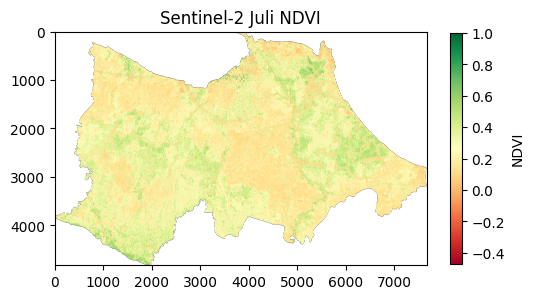

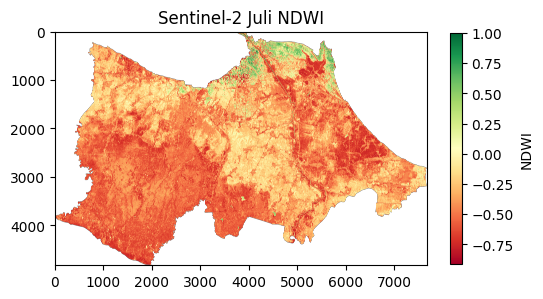

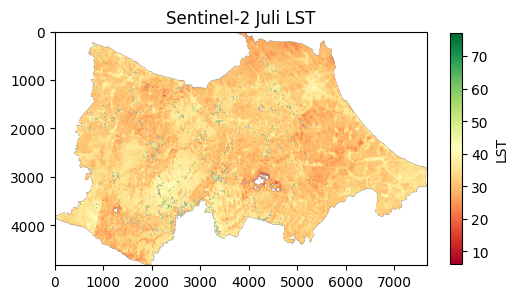

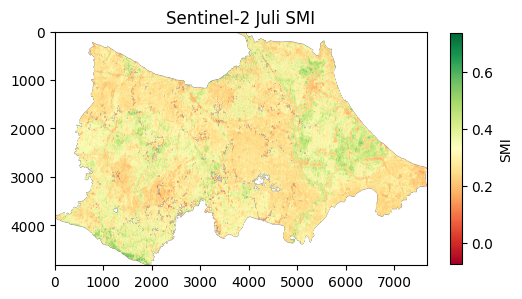

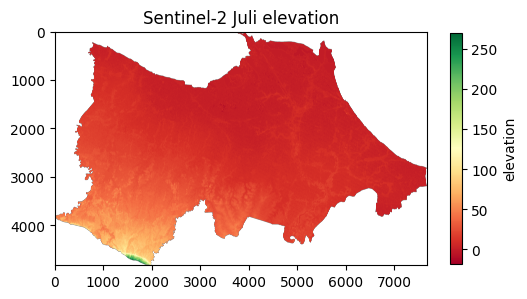

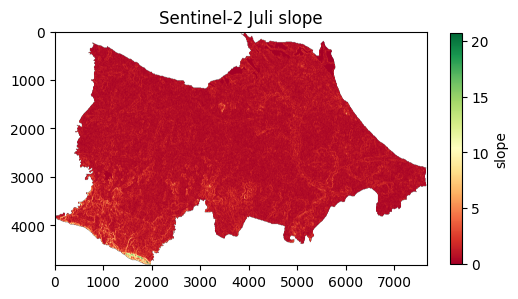

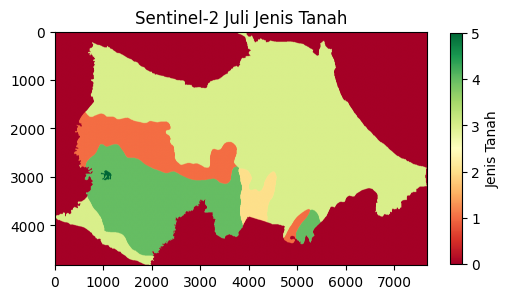

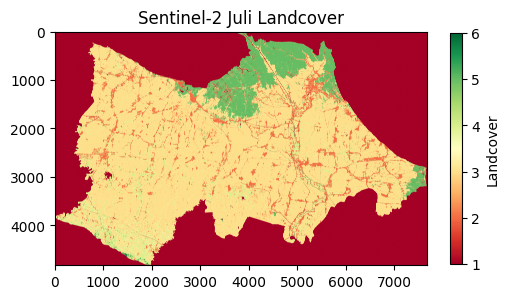

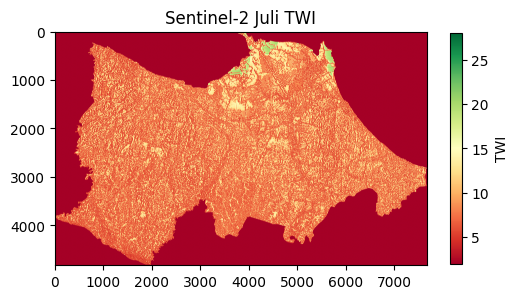

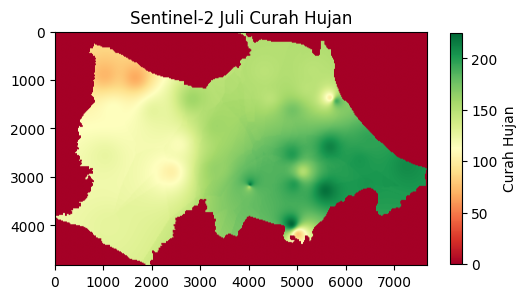

In [ ]:
# Import the necessary module
import matplotlib.pyplot as plt

# List nama spectral index
spectral_index_names = ['NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope', 'Jenis Tanah', 'Landcover', 'TWI', 'Curah Hujan']

# Start index untuk VCI adalah index ke 8
start_index = 7

# Loop untuk semua spectral index dan plot semuanya
for i, index_name in enumerate(spectral_index_names):
    plt.figure(figsize=(6, 6))

    # Ambil band yang sesuai dari array S2_juli
    band_data = S2_juli[:, :, start_index + i]

    # Jika spectral index adalah 'Landcover', batasi nilai antara 1 dan 6
    if index_name == 'Landcover':
        band_data = np.clip(band_data, 1, 6)  # Batasi nilai antara 1 dan 6

    # Jika spectral index adalah 'TWI', batasi nilai antara 1.94678 dan 33.6868
    elif index_name == 'TWI':
        band_data = np.clip(band_data, 1.94678, 33.6868)  # Batasi nilai antara 1.94678 dan 33.6868

    # Jika spectral index adalah 'Curah Hujan', batasi nilai antara 67 dan 225
    elif index_name == 'Curah Hujan':
        band_data = np.clip(band_data, 0, 225)  # Batasi nilai antara 67 dan 225

    # Plot data
    plt.imshow(band_data, cmap='RdYlGn')
    plt.colorbar(label=index_name, shrink=0.5)
    plt.title(f'Sentinel-2 Juli {index_name}')
    plt.show()

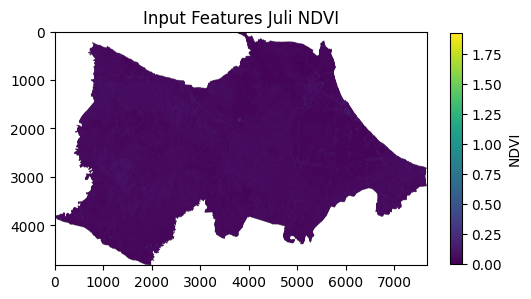

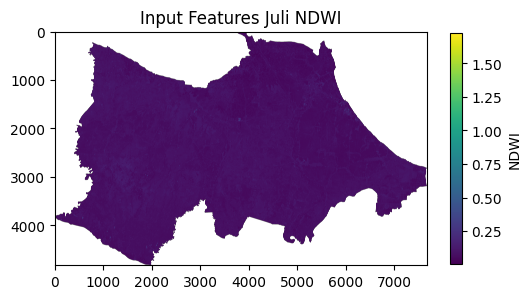

KeyboardInterrupt: 

In [ ]:
# # Membuat Loop untuk plotting semua features sekaligus:

# # List nama features
# spectral_index_names = ['NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope', 'Jenis Tanah', 'Landcover', 'TWI', 'CURAH HUJAN']

# # Loop untuk semua features  dan plot semuanya
# for i, index_name in enumerate(spectral_index_names):
#     plt.figure(figsize=(6, 6))
#     plt.imshow(S2_juli[:, :, i], cmap='viridis')
#     plt.colorbar(label=index_name, shrink=0.5)
#     plt.title(f'Input Features Juli {index_name}')
#     plt.show()

## Pembuatan sample point (Final features (17 bands) dan target dari titik preprocessed SPI bulanan)

##### Apabila tidak ada band yang ditambahkan bisa import langsung data dari sini

In [ ]:
# # Memangggil data L8 yang sudah dimasukkan kedalam google drive kita
# L8_dataset_juli = rasterio.open('/content/drive/MyDrive/Geosoftware_Kekeringan_SPI_New/L8_Juli_2024.tif')
# L8_dataset_agustus = rasterio.open('/content/drive/MyDrive/Geosoftware_Kekeringan_SPI_New/L8_Agustus_2024.tif')
# L8_dataset_september = rasterio.open('/content/drive/MyDrive/Geosoftware_Kekeringan_SPI_New/L8_September_2024.tif')
# # L8_dataset_oktober = rasterio.open('/content/drive/MyDrive/Geosoftware_Kekeringan_SPI_New/L8_Oktober_2024.tif')

# L8_juli = L8_dataset_juli.read().transpose(1, 2, 0)

# L8_agustus = L8_dataset_agustus.read().transpose(1, 2, 0)

# L8_september = L8_dataset_september.read().transpose(1, 2, 0)

# # L8_oktober = L8_dataset_oktober.read().transpose(1, 2, 0)

# L8_september.shape

In [ ]:
# Function to check NaN values in each band
def check_nan_values(dataset, month_name):
    nan_counts = np.isnan(dataset).sum(axis=(0, 1))  # Sum NaN values for each band
    print(f"NaN counts for {month_name}:")
    for i, count in enumerate(nan_counts):
        print(f"  Band {i+1}: {count} NaN values")
    print("-" * 40)

# Check NaN values for each dataset
check_nan_values(S2_juli, "July")
check_nan_values(S2_agustus, "August")
check_nan_values(S2_september, "September")
check_nan_values(S2_oktober, "October")

NaN counts for July:
  Band 1: 16103973 NaN values
  Band 2: 16103973 NaN values
  Band 3: 16103973 NaN values
  Band 4: 16103973 NaN values
  Band 5: 16103985 NaN values
  Band 6: 16103973 NaN values
  Band 7: 16103973 NaN values
  Band 8: 16103973 NaN values
  Band 9: 16103985 NaN values
  Band 10: 16352787 NaN values
  Band 11: 16352787 NaN values
  Band 12: 16109077 NaN values
  Band 13: 16228835 NaN values
  Band 14: 0 NaN values
  Band 15: 0 NaN values
  Band 16: 0 NaN values
  Band 17: 0 NaN values
----------------------------------------
NaN counts for August:
  Band 1: 16103973 NaN values
  Band 2: 16103973 NaN values
  Band 3: 16103973 NaN values
  Band 4: 16103973 NaN values
  Band 5: 16103973 NaN values
  Band 6: 16103973 NaN values
  Band 7: 16103973 NaN values
  Band 8: 16103973 NaN values
  Band 9: 16103973 NaN values
  Band 10: 16296815 NaN values
  Band 11: 16296815 NaN values
  Band 12: 16109077 NaN values
  Band 13: 16228835 NaN values
  Band 14: 0 NaN values
  Band 

In [ ]:
# Normalisasi nilai value setiap band menggunakan standard scaler
from sklearn.preprocessing import StandardScaler
import numpy as np

def normalize_bands_standard(rs_image):
    # menginisiasi empty array
    normalized_image = np.zeros_like(rs_image, dtype=np.float32)

    # menambahkan fungsi standardscaler
    scaler = StandardScaler()

    # Normalize setiap band menggunakan standardscaler
    for band in range(rs_image.shape[2]):
        band_data = rs_image[:, :, band]

        # Flatten band kedalam 1D array
        band_data_flattened = band_data.flatten().reshape(-1, 1)

        # apply untuk setiap band
        scaled_band = scaler.fit_transform(band_data_flattened)

        # Reshape kembali ke shape awal
        normalized_image[:, :, band] = scaled_band.reshape(band_data.shape)

    return normalized_image

In [ ]:
# Menerapkan fungsi standardscaler
S2_juli = normalize_bands_standard(S2_juli)
S2_agustus = normalize_bands_standard(S2_agustus)
S2_september = normalize_bands_standard(S2_september)
S2_oktober = normalize_bands_standard(S2_oktober)

In [ ]:
S2_juli.shape

(4824, 7677, 17)

In [ ]:
# chek hasil normalisasi
np.nanmean(S2_juli[:,:,8])

np.float32(-1.1975143e-07)

In [ ]:
# Import shapefile samples:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.transform import rowcol


shapefile_juli = gpd.read_file("/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/2spispi_Juli.shp")
shapefile_agustus = gpd.read_file("/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/2spispi_Agustus.shp")
shapefile_september = gpd.read_file("/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/2spispi_September.shp")
shapefile_oktober = gpd.read_file("/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/2spispi_Oktober.shp")

In [ ]:
shapefile_juli.head()

,X,Y,Stasiun,SPI2,Stasiun_ID,geometry
0,107.958767,-6.376123,arx,-2.260953,1,POINT (107.95877 -6.37612)
1,108.034561,-6.377950,arx,-2.974363,1,POINT (108.03456 -6.37795)
2,108.077790,-6.440240,arx,-2.937449,1,POINT (108.07779 -6.44024)
3,107.951112,-6.589091,arx,-2.334841,1,POINT (107.95111 -6.58909)
4,107.943378,-6.460257,arx,-2.349900,1,POINT (107.94338 -6.46026)


In [ ]:
print(shapefile_juli.shape, shapefile_agustus.shape, shapefile_september.shape, shapefile_oktober.shape)

(232, 6) (232, 6) (232, 6) (232, 6)


In [ ]:
# Membuat fungsi untuk extract raster values dari point
import numpy as np
import rasterio
from rasterio.transform import rowcol

def extract_pixels_from_shapefile(shapefile_juli, shapefile_agustus, shapefile_september, shapefile_oktober,
                                  S2_juli, S2_agustus, S2_september, S2_oktober, transform):

    def extract_from_shapefile(shapefile, S2_data):
        features_list, targets_list, coords_list = [], [], []

        for _, row in shapefile.iterrows():
            x, y = row.geometry.x, row.geometry.y  # Extract coordinates
            row_idx, col_idx = rowcol(transform, x, y)  # Convert to raster indices

            # Ensure the indices are within bounds
            if (0 <= row_idx < S2_data.shape[0]) and (0 <= col_idx < S2_data.shape[1]):
                features_list.append(S2_data[row_idx, col_idx, :])  # Extract band values
                targets_list.append(row["SPI2"])  # Extract SPI2
                coords_list.append([x, y])  # Save coordinates

        return np.array(features_list), np.array(targets_list).reshape(-1, 1), np.array(coords_list)

    # Extract data untuk setiap bulan
    features_juli, targets_juli, coords_juli = extract_from_shapefile(shapefile_juli, S2_juli)
    features_agustus, targets_agustus, coords_agustus = extract_from_shapefile(shapefile_agustus, S2_agustus)
    features_september, targets_september, coords_september = extract_from_shapefile(shapefile_september, S2_september)
    features_oktober, targets_oktober, coords_oktober = extract_from_shapefile(shapefile_oktober, S2_oktober)


    # Stack semua bulan
    features = np.vstack([features_juli, features_agustus, features_september, features_oktober])
    targets = np.vstack([targets_juli, targets_agustus, targets_september, targets_oktober])
    coords = np.vstack([coords_juli, coords_agustus, coords_september, coords_oktober])

    return features, targets, coords

        features_list, targets_list, coords_list = [], [], []

        for _, row in shapefile.iterrows():
            x, y = row.geometry.x, row.geometry.y  # Extract coordinates
            row_idx, col_idx = rowcol(transform, x, y)  # Convert to raster indices

            # Ensure the indices are within bounds
            if (0 <= row_idx < S2_data.shape[0]) and (0 <= col_idx < S2_data.shape[1]):
                features_list.append(S2_data[row_idx, col_idx, :])  # Extract band values
                targets_list.append(row["SPI2"])  # Extract SPI2
                coords_list.append([x, y])  # Save coordinates

        return np.array(features_list), np.array(targets_list).reshape(-1, 1), np.array(coords_list)

    # Extract data untuk setiap bulan
    features_juli, targets_juli, coords_juli = extract_from_shapefile(shapefile_juli, S2_juli)
    features_agustus, targets_agustus, coords_agustus = extract_from_shapefile(shapefile_agustus, S2_agustus)
    features_september, targets_september, coords_september = extract_from_shapefile(shapefile_september, S2_september)
    features_oktober, targets_oktober, coords_oktober = extract_from_shapefile(shapefile_oktober, S2_oktober)


    # Stack semua bulan
    features = np.vstack([features_juli, features_agustus, features_september, features_oktober])
    targets = np.vstack([targets_juli, targets_agustus, targets_september, targets_oktober])
    coords = np.vstack([coords_juli, coords_agustus, coords_september, coords_oktober])

    return features, targets, coords

IndentationError: unexpected indent (<ipython-input-37-7d596a60e3ff>, line 42)

In [ ]:
# Membuat fungsi untuk extract raster values dari point
import numpy as np
import rasterio
from rasterio.transform import rowcol

def extract_pixels_from_shapefile(shapefile_juli, shapefile_agustus, shapefile_september, shapefile_oktober,
                                  S2_juli, S2_agustus, S2_september, S2_oktober, transform):

    def extract_from_shapefile(shapefile, S2_data):
        features_list, targets_list, coords_list = [], [], []

        for _, row in shapefile.iterrows():
            x, y = row.geometry.x, row.geometry.y  # Extract coordinates
            row_idx, col_idx = rowcol(transform, x, y)  # Convert to raster indices

            # Ensure the indices are within bounds
            if (0 <= row_idx < S2_data.shape[0]) and (0 <= col_idx < S2_data.shape[1]):
                features_list.append(S2_data[row_idx, col_idx, :])  # Extract band values
                targets_list.append(row["SPI2"])  # Extract SPI2
                coords_list.append([x, y])  # Save coordinates

        return np.array(features_list), np.array(targets_list).reshape(-1, 1), np.array(coords_list)

    # Extract data untuk setiap bulan
    features_juli, targets_juli, coords_juli = extract_from_shapefile(shapefile_juli, S2_juli)
    features_agustus, targets_agustus, coords_agustus = extract_from_shapefile(shapefile_agustus, S2_agustus)
    features_september, targets_september, coords_september = extract_from_shapefile(shapefile_september, S2_september)
    features_oktober, targets_oktober, coords_oktober = extract_from_shapefile(shapefile_oktober, S2_oktober)


    # Stack semua bulan
    features = np.vstack([features_juli, features_agustus, features_september, features_oktober])
    targets = np.vstack([targets_juli, targets_agustus, targets_september, targets_oktober])
    coords = np.vstack([coords_juli, coords_agustus, coords_september, coords_oktober])

    return features, targets, coords

In [ ]:
# Menerapkan fungsi:
features, targets, coords = extract_pixels_from_shapefile(
    shapefile_juli, shapefile_agustus, shapefile_september, shapefile_oktober,
    S2_juli, S2_agustus, S2_september, S2_oktober, transform
)

In [ ]:
print("Feature data shape:", features.shape)
print("Target data shape:", targets.shape)
print("Coordinates shape:", coords.shape)

Feature data shape: (813, 17)
Target data shape: (813, 1)
Coordinates shape: (813, 2)


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Mendefinisikan columns
column_names = [f'Band_{i+1}' for i in range(features.shape[1])] + ['SPI2']

# Menggabungkan features dan target
data = np.hstack([features, targets])
df = pd.DataFrame(data, columns=column_names)

# Convert coordinat ke geodataform
geometry = [Point(xy) for xy in coords]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # Change CRS if needed

# Save ke shapefile
output_shapefile = "/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/spispi_Extracted_Samples.shp"
gdf.to_file(output_shapefile, driver='ESRI Shapefile')

## Persiapan Input Data dan Training Random Forest

* Setelah mendapatkan input faetures dan target data, langkah selanjutnya adalah membuat training dan testing data

* kemudian kita akan menggunakan algoritma random forest regression untuk keperluan regresi hasil


In [ ]:
# Import Library yang dibutuhkan
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split

# X_train adalah features untuk training
# X_test aladah features untuk testing
#y_train adalah target atau label training
# y_test adalah traget atau label untuk testing

# Split data: 80% for training and 20% for testing
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    features, targets, coords, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, coords_train.shape, coords_test.shape)

(650, 17) (163, 17) (650, 1) (163, 1) (650, 2) (163, 2)


#### Filter-out sample yang terdapat nan value

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Membuat fungsi untuk nan map
def create_nan_map(X, y):
    y = np.ravel(y)
    # filter nan apabila ada nan value pada data X dan y
    nan_map = np.isnan(X).any(axis=1) | np.isnan(y)
    return nan_map

# membuat fungsi untuk menghapus nan value
def remove_nans(X, y, coords):
    # membuat nan map
    nan_map = create_nan_map(X, y)

    # apply nan map pada data x dan y
    X_clean = X[~nan_map]
    y_clean = y[~nan_map]
    coords_clean = coords[~nan_map]

    return X_clean, y_clean, coords_clean

# Menerapkan fungsi
X_train, y_train, coords_train = remove_nans(X_train, y_train, coords_train)
X_test, y_test, coords_test = remove_nans(X_test, y_test, coords_test)

print("Training set setelah menghapus nan:", X_train.shape, y_train.shape)
print("Testing set setelah menghapus nan:", X_test.shape, y_test.shape)

Training set setelah menghapus nan: (443, 17) (443, 1)
Testing set setelah menghapus nan: (106, 17) (106, 1)


##### Export train dan testing data kedalam shapefle

In [ ]:
# Export train data
# Mendefinisikan columns
column_names = [f'Band_{i+1}' for i in range(X_train.shape[1])] + ['SPI2']

# Menggabungkan features dan target
data_train = np.hstack([X_train, y_train])
df_train = pd.DataFrame(data_train, columns=column_names)

# Convert coordinat ke geodataform
geometry_train = [Point(xy) for xy in coords_train]
gdf_train = gpd.GeoDataFrame(df_train, geometry=geometry_train, crs="EPSG:4326")  # Change CRS if needed

# Save ke shapefile
output_shapefile_train = "/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/spispi_training_Samples.shp"
gdf_train.to_file(output_shapefile_train, driver='ESRI Shapefile')

In [ ]:
# Export test data
# Mendefinisikan columns
column_names = [f'Band_{i+1}' for i in range(X_test.shape[1])] + ['SPI2']

# Menggabungkan features dan target
data_test = np.hstack([X_test, y_test])
df_test = pd.DataFrame(data_test, columns=column_names)

# Convert coordinat ke geodataform
geometry_test = [Point(xy) for xy in coords_test]
gdf_test = gpd.GeoDataFrame(df_test, geometry=geometry_test, crs="EPSG:4326")  # Change CRS if needed

# Save ke shapefile
output_shapefile_test = "/content/drive/MyDrive/Mustika/Faktor Fisik/DATA SPI UPDATE/spispi_Testing_samples.shp"
gdf_test.to_file(output_shapefile_test, driver='ESRI Shapefile')

## Random Forest Training Process and Evaluation Assessment
Pada part ini kita akan melakukan training Random Forest Regression menggunakan gridsearch cv untuk mencari parameter terbaik.

In [ ]:
# Import RF classifier dari library sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Cross Validation mengambil sebagian data training secara random yang nantinya akan dijadikan validasi untuk menghitung akurasi / performa model selama pelatihan

In [ ]:
# Random forest model awal
init_rf_model = RandomForestRegressor(random_state=42)

# Mendeifiniskan list beberapa parameter yang akan digunakan untuk hyperparameter tuning
param_grid = {
     'n_estimators': [100, 300, 500],
     'max_depth': [None, 10, 20, 30],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4],
     'max_features': ['sqrt', 'log2', None]
}

In [ ]:
# GridSearchCV dengan 5-fold cross-validation
grid_search = GridSearchCV(init_rf_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=5)

In [ ]:
import time

# Start the timer
start_time = time.time()

# Train RF model model dengan grid_search
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Waktu yang dibutuhkan untuk running adalah: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Waktu yang dibutuhkan untuk running adalah: 40.377 seconds


In [ ]:
# Print the best parameters
print("Best parameters adalah:", grid_search.best_params_)
print("Best cross-validation negatif MAE:", grid_search.best_score_)

Best parameters adalah: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation negatif MAE: -0.4332216509138395


In [ ]:
# Evaluation assessment untuk regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Menerapkan best parameter RFr
best_rf = grid_search.best_estimator_

# Menerapkan RF model untuk memprediksi kelas dari tetsing dataset
y_pred_grid = best_rf.predict(X_test)

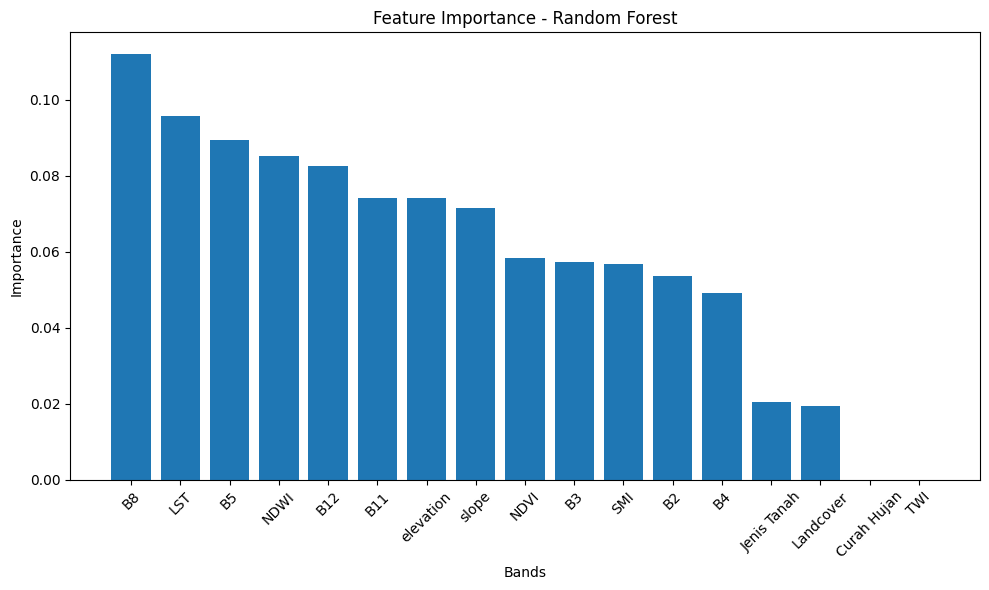

In [ ]:
band_names = ['B2', 'B3', 'B4', 'B5', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'LST', 'SMI', 'elevation', 'slope', 'Jenis Tanah', 'Landcover', 'TWI', 'Curah Hujan']

# mendapatkan feature importance
importances = best_rf.feature_importances_

# Sort feature importances
sorted_idx = np.argsort(importances)[::-1]

# Sort feature importances dan band names
sorted_importances = importances[sorted_idx]
sorted_band_names = np.array(band_names)[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_band_names, rotation=45)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Bands')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Membuat evaluation function untuk mempermudah kedepannya (untuk regression)
def evaluate_regression(y_true, y_pred):
    # Perhitungan Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Perhitungan Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    # Perhitungan Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Perhitungan R-squared (R²)
    r2 = r2_score(y_true, y_pred)
    print(f"R-squared (R²): {r2:.4f}")

    # Visualisasi Predicted vs Actual using scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linewidth=2)
    plt.xlabel('True SPI Values')
    plt.ylabel('Predicted SPI Values')
    plt.title('True vs Predicted Values', fontsize=14)
    plt.show()



In [ ]:
y_pred_grid.shape

(106,)

Mean Absolute Error (MAE): 0.4428
Mean Squared Error (MSE): 0.3196
Root Mean Squared Error (RMSE): 0.5654
R-squared (R²): 0.1038


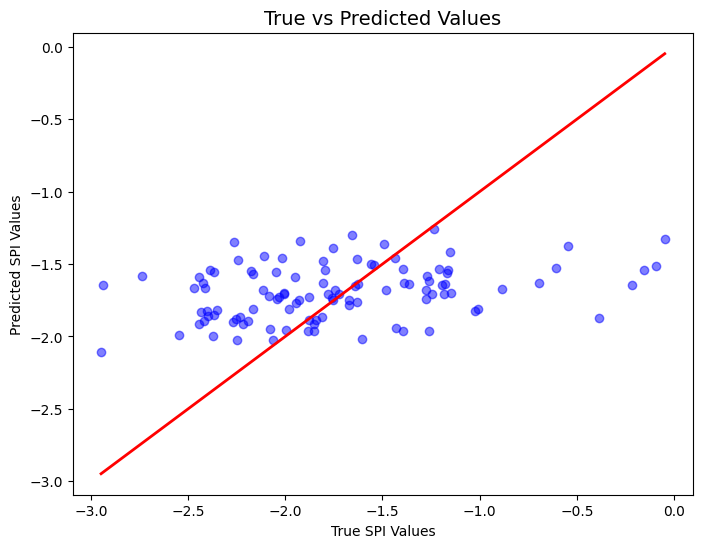

In [ ]:
# Menerapkan function evaluation assessment dengan data yang sebenarnya atau y_test dan data hasil prediksi
evaluate_regression(y_test, y_pred_grid)

In [ ]:
import joblib

# Save the model
joblib.dump(best_rf, '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/bestt_RF_Reg_kekeringan_model.pkl')

['/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/bestt_RF_Reg_kekeringan_model.pkl']

## Membuat Peta Kekeringan Berdasarkan RF regression Trained Model
Pada part ini, kita akan menghasilkan peta penutup lahan menggunakan model Random FOrest Regression yang telah dilatih. Kita akan menerapkannya pada setiap bulan.

In [ ]:
# import AOi kita menggunakan geopandas
import geopandas as gpd

AOI = gpd.read_file('/content/drive/MyDrive/Mustika/Batas Admin Indramayu/Batas Admin/Admin_IM.shp')

In [ ]:
# Apply model untuk mendapatkan peta SPI keseluruhan citra Landsat8
def classify_raster(raster, model):
    raster_data = raster.reshape(-1, raster.shape[2])  # Reshape to (pixels, bands)
    mask = np.isnan(raster_data).any(axis=1)  # Exclude NaN pixels
    classified = np.full(raster_data.shape[0], np.nan)
    classified[~mask] = model.predict(raster_data[~mask])
    return classified.reshape((raster.shape[0], raster.shape[1]))

# terapkan function classify_raster
classified_map_juli = classify_raster(S2_juli, best_rf)

In [ ]:
classified_map_agustus = classify_raster(S2_agustus, best_rf)

In [ ]:
classified_map_september = classify_raster(S2_september, best_rf)

In [ ]:
classified_map_oktober = classify_raster(S2_oktober, best_rf)

In [ ]:
classified_map_juli.shape

(4824, 7677)

In [ ]:
np.nanmin(classified_map_agustus)

np.float64(-2.325339698032472)

### Visualisasi Peta Kekeringan SPI

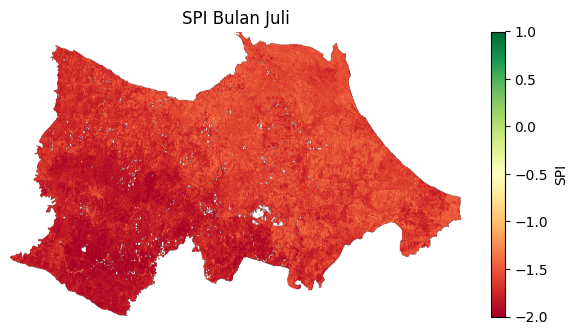

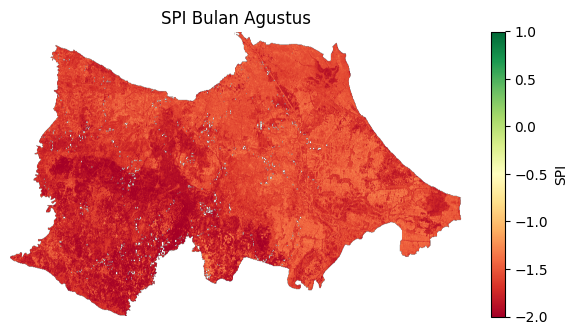

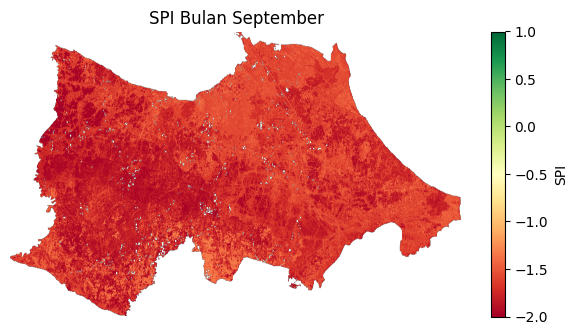

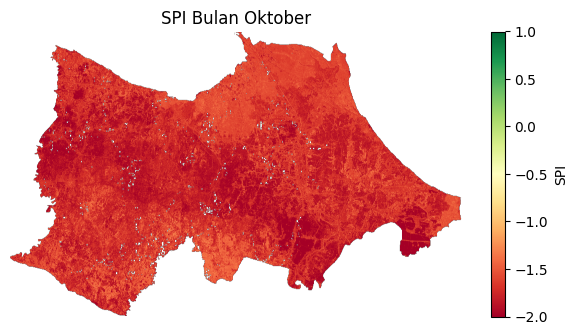

In [ ]:
# Visualisasi Hasil Peta SPI Menggunakan Random Forest

# List data SPI dan judul
# SPI_data = [classified_map_juli, classified_map_agustus, classified_map_september, classified_map_oktober]
# titles = ['SPI Bulan Juli', 'SPI Bulan Agustus', 'SPI Bulan September', 'SPI Bulan Oktober']

SPI_data = [classified_map_juli, classified_map_agustus, classified_map_september, classified_map_oktober]
titles = ['SPI Bulan Juli', 'SPI Bulan Agustus', 'SPI Bulan September', 'SPI Bulan Oktober']

# Batasan nilai minimum dan maksimum
vmin, vmax = -2, 1

# Loop untuk membuat plot
for i, data in enumerate(SPI_data):
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap='RdYlGn', \
               vmin=vmin, vmax=vmax, \
               extent=[AOI.total_bounds[0], AOI.total_bounds[2],AOI.total_bounds[1],\
                       AOI.total_bounds[3]])
    plt.colorbar(label='SPI', shrink=0.5)
    plt.title(titles[i])
    plt.axis('off')  # Matikan axis
    plt.tight_layout()
    plt.show()


### Export raster hasil klasifikasi

In [ ]:
# !pip install rasterio

In [ ]:
import rasterio
from rasterio.transform import from_origin

def export_spi_map(classified_map, S2_meta, output_path):
    # Mendapatkan metadata dari data Landsat-8
    meta = S2_meta

    # Update the metadata
    meta.update({
        "driver": "GTiff",
        "dtype": 'float32',
        "count": 1,        # Hanya satu band
        "compress": "lzw"  # file compression
    })

    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(classified_map.astype('float32'), 1)

# Menerapkan fungsi yang telah dibuat untuk setiap bulan

# Juli
output_tif_path_juli = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasill_Peta_SPI_Juli.tif'
export_spi_map(classified_map_juli, S2_meta, output_tif_path_juli)

In [ ]:
# Agustus
output_tif_path_agustus = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasill_Peta_SPI_Agustus.tif'
export_spi_map(classified_map_agustus, S2_meta, output_tif_path_agustus)

In [ ]:
# September
output_tif_path_september = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasill_Peta_SPI_September.tif'
export_spi_map(classified_map_september, S2_meta, output_tif_path_september)

In [ ]:
# oktober
output_tif_path_oktober = '/content/drive/MyDrive/Mustika/Faktor Fisik/Hasil_Peta_SPI_Oktober.tif'
export_spi_map(classified_map_oktober, S2_meta, output_tif_path_oktober)

### Reklasifikasi SPI menjadi kelas kekeringan


In [ ]:
import rasterio
import numpy as np

# import AOi kita menggunakan geopandas
import geopandas as gpd

AOI = gpd.read_file('/content/drive/MyDrive/Mustika/Batas Admin Indramayu/Batas Admin/Admin_IM.shp')

# Define file paths
output_tif_path_juli = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasill_Peta_SPI_Juli.tif'
output_tif_path_agustus = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasill_Peta_SPI_Agustus.tif'
output_tif_path_september = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasill_Peta_SPI_September.tif'
output_tif_path_oktober = '/content/drive/MyDrive/Mustika/Faktor Fisik/Hasil_Peta_SPI_Oktober.tif'

# Function to read raster data using rasterio
def read_tif(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first band
        meta = src.meta
        return data, meta

# Import the exported SPI maps
classified_map_juli, S2_meta = read_tif(output_tif_path_juli)
classified_map_agustus, S2_meta = read_tif(output_tif_path_agustus)
classified_map_september, S2_meta = read_tif(output_tif_path_september)
classified_map_oktober, S2_meta = read_tif(output_tif_path_oktober)

# Check the shape of one of the imported arrays (just to confirm)
print("Juli SPI shape:", classified_map_juli.shape)
print("Agustus SPI shape:", classified_map_agustus.shape)
print("September SPI shape:", classified_map_september.shape)
print("Oktober SPI shape:", classified_map_oktober.shape)


Juli SPI shape: (4824, 7677)
Agustus SPI shape: (4824, 7677)
September SPI shape: (4824, 7677)
Oktober SPI shape: (4824, 7677)


In [ ]:
print(np.nanmax(classified_map_juli), np.nanmin(classified_map_juli), np.nanmean(classified_map_juli))

-0.9994121 -2.34496 -1.7003012


In [ ]:
print(np.nanmax(classified_map_agustus), np.nanmin(classified_map_agustus), np.nanmean(classified_map_agustus))

-1.0558692 -2.3253398 -1.6673212


In [ ]:
print(np.nanmax(classified_map_september), np.nanmin(classified_map_september), np.nanmean(classified_map_september))

-1.083975 -2.30982 -1.7043698


In [ ]:
def reclassify_SPI(spi):
    reclassified = np.full_like(spi, np.nan, dtype=float)  # Initialize with NaN

    reclassified[spi >= 2.0] = 1  # Extremely wet
    reclassified[(spi >= 1.5) & (spi < 2.0)] = 2  # Very wet
    reclassified[(spi >= 1.0) & (spi < 1.5)] = 3  # Moderately wet
    reclassified[(spi >= -0.99) & (spi < 1.0)] = 4  # Near normal
    reclassified[(spi >= -1.49) & (spi < -0.99)] = 5  # Moderately dry
    reclassified[(spi >= -1.99) & (spi < -1.5)] = 6  # Severely dry
    reclassified[spi < -2.0] = 7  # Extremely dry

    return reclassified

In [ ]:
# Menerapkan fungsi reklasifikasi kedalam setiap bulan SPI
rec_SPI_juli = reclassify_SPI(classified_map_juli)
rec_SPI_agustus = reclassify_SPI(classified_map_agustus)
rec_SPI_september = reclassify_SPI(classified_map_september)
rec_SPI_oktober = reclassify_SPI(classified_map_oktober)

In [ ]:
# Cek hasil reklasifikasi
print(np.unique(rec_SPI_juli),np.unique(rec_SPI_agustus),np.unique(rec_SPI_september))

[ 5.  6.  7. nan] [ 5.  6.  7. nan] [ 5.  6.  7. nan]


In [ ]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Mendefinisikan Legend dan warna untuk setiap kelas
# legend_labels = ['Extremely wet', 'Very wet', 'Moderately wet', 'Near normal', 'Moderately dry','Severely dry','Extremely dry']
# legend_colors = ['blue', 'orange', 'yellow', 'green', 'gray', 'purple','red']
legend_labels = [ 'Moderately dry','Severely dry', 'ExtremeDry']
legend_colors = [ 'lightgreen', 'orange', 'red']

# Membuat figure untuk 2 row dan 2 column subplots
fig, ax = plt.subplots(2, 2, figsize=(18, 16))  # 2x2 grid, increased height for better readability

# Mendefinisikan colormap
cmap = ListedColormap(legend_colors)

# Display hasil reklasifikasi SPI untuk bulan Juli
im = ax[0, 0].imshow(rec_SPI_juli, cmap=cmap, extent=[AOI.total_bounds[0], AOI.total_bounds[2], AOI.total_bounds[1], AOI.total_bounds[3]])
ax[0, 0].set_title('Peta Klasifikasi Reklasifikasi SPI Juli')

# Display hasil reklasifikasi SPI untuk bulan Agustus
im = ax[0, 1].imshow(rec_SPI_agustus, cmap=cmap, extent=[AOI.total_bounds[0], AOI.total_bounds[2], AOI.total_bounds[1], AOI.total_bounds[3]])
ax[0, 1].set_title('Peta Klasifikasi Reklasifikasi SPI Agustus')

# Display hasil reklasifikasi SPI untuk bulan September
im = ax[1, 0].imshow(rec_SPI_september, cmap=cmap, extent=[AOI.total_bounds[0], AOI.total_bounds[2], AOI.total_bounds[1], AOI.total_bounds[3]])
ax[1, 0].set_title('Peta Klasifikasi Reklasifikasi SPI September')

# Display hasil reklasifikasi SPI untuk bulan Oktober
im = ax[1, 1].imshow(rec_SPI_oktober, cmap=cmap, extent=[AOI.total_bounds[0], AOI.total_bounds[2], AOI.total_bounds[1], AOI.total_bounds[3]])
ax[1, 1].set_title('Peta Klasifikasi Reklasifikasi SPI Oktober')

# Membuat legend
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]

# Menambahkan legend ke dalam plot pada subplot yang pertama (ax[0, 0])
ax[0, 0].legend(handles=legend_handles, loc='upper right', title="Kelas Kekeringan", fontsize='x-small', title_fontsize='medium', edgecolor="black", fancybox=True)
ax[0, 1].legend(handles=legend_handles, loc='upper right', title="Kelas Kekeringan", fontsize='x-small', title_fontsize='medium', edgecolor="black", fancybox=True)
# ax[1, 1].legend(handles=legend_handles, loc='upper left', title="Kelas Kekeringan", fontsize='x-small', title_fontsize='medium', edgecolor="black", fancybox=True)
ax[1, 0].legend(handles=legend_handles, loc='upper right', title="Kelas Kekeringan", fontsize='x-small', title_fontsize='medium', edgecolor="black", fancybox=True)

# Menyesuaikan tata letak agar tidak tumpang tindih
plt.tight_layout()

# Menyimpan gambar jika diperlukan
# plt.savefig('/content/drive/MyDrive/Geosoftware_Kekeringan_SPI/Peta_Kekeringan_Reklasifikasi_SPI_Setiap_Bulan.jpeg', dpi=600)

# Menampilkan plot
plt.show()


In [ ]:
!pip install rasterio

In [ ]:
import rasterio
import numpy as np

def export_classified_map(classified_map, L8_meta, output_path, no_data_value=-9999):
    # Copy metadata
    meta = L8_meta

    # Update  metadata
    meta.update({
        "driver": "GTiff",
        "dtype": "int32",  # For integer class
        "count": 1,        # Single-band raster
        "compress": "lzw",  # File compression
        "nodata": no_data_value  # Define no-data value
    })

    # Replace NaN values with the specified no-data value
    classified_map = np.nan_to_num(classified_map, nan=no_data_value).astype("int32")

    # Write to the output GeoTIFF file
    with rasterio.open(output_path, "w", **meta) as dst:
        dst.write(classified_map, 1)


In [ ]:
# Menerapkan fungsi yang telah dibuat untuk setiap bulan
# Juli
output_tif_path_juli = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasil_Rec_SPI_Juli.tif'
export_classified_map(rec_SPI_juli, S2_meta, output_tif_path_juli)

In [ ]:
# Menerapkan fungsi yang telah dibuat untuk setiap bulan
# Agustus
output_tif_path_agustus = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasil_Rec_SPI_Agustus.tif'
export_classified_map(rec_SPI_agustus, S2_meta, output_tif_path_agustus)

In [ ]:
# Menerapkan fungsi yang telah dibuat untuk setiap bulan
# September
output_tif_path_september = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasil_Rec_SPI_september.tif'
export_classified_map(rec_SPI_september, S2_meta, output_tif_path_september)

In [ ]:
# Menerapkan fungsi yang telah dibuat untuk setiap bulan
# oktober
output_tif_path_oktober = '/content/drive/MyDrive/Mustika/DATA CH SPI/SHP SPI/NEW/NEW2/Hasil_Rec_SPI_oktober.tif'
export_classified_map(rec_SPI_oktober, S2_meta, output_tif_path_oktober)

### Analisis luasan kekeringan

            Class        Juli     Agustus   September
0   Extremely wet        0.00        0.00        0.00
1        Very wet        0.00        0.00        0.00
2  Moderately wet        0.00        0.00        0.00
3     Near normal        0.00        0.00        0.00
4  Moderately dry   223903.71   357575.49   242421.39
5    Severely dry  1486599.66  1362679.02  1467843.21
6   Extremely dry   101022.21    92020.68   102971.34


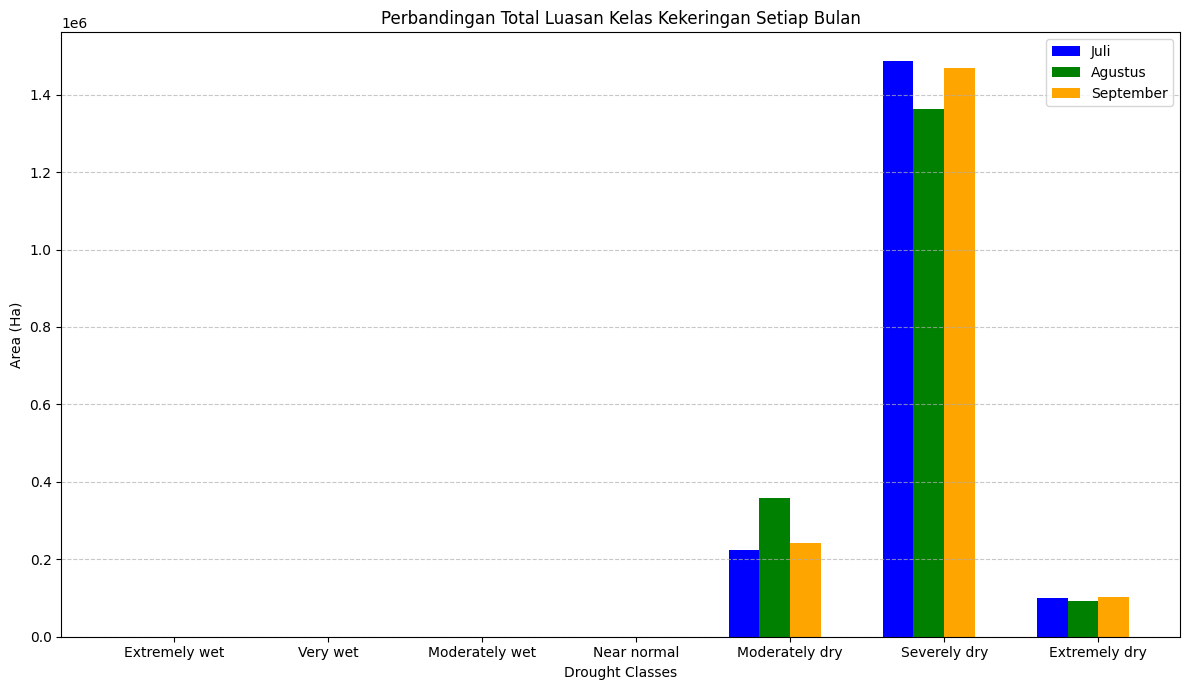

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mendefiniskan Label
labels = ['Extremely wet', 'Very wet', 'Moderately wet', 'Near normal', 'Moderately dry','Severely dry','Extremely dry']
classes = [1, 2, 3, 4, 5, 6, 7]
pixel_area_ha = 0.09 # untuk landsat 30x30 m

# Membuat fungsi untuk menghitung luas area masing-masing kelas
def calculate_class_areas(classified_map, classes, pixel_area_ha):
    areas = {}
    total_area = 0
    # Ignore NaN values
    classified_map = np.nan_to_num(classified_map, nan=0)
    for cls in classes:
        # Menghitung total pixel setiap kelas
        pixel_count = np.sum(classified_map == cls)
        # Convert pixel ke hektar
        area = pixel_count * pixel_area_ha
        areas[cls] = area
        total_area += area  # Accumulate total area
    return areas, total_area

# Menghitung luasan setiap bulan
areas_juli, total_area_juli = calculate_class_areas(rec_SPI_juli, classes, pixel_area_ha)
areas_agustus, total_area_agustus = calculate_class_areas(rec_SPI_agustus, classes, pixel_area_ha)
areas_september, total_area_september = calculate_class_areas(rec_SPI_september, classes, pixel_area_ha)
# areas_oktober, total_area_oktober = calculate_class_areas(rec_SPI_oktober, classes, pixel_area_ha)

# Membuat pandas dataframe untuk memudhkan kedepannya
# area_df = pd.DataFrame({
#     "Class": labels,
#     "Juli": [areas_juli[cls] for cls in classes],
#     "Agustus": [areas_agustus[cls] for cls in classes],
#     "September": [areas_september[cls] for cls in classes],
#     "Oktober": [areas_oktober[cls] for cls in classes]
# })

area_df = pd.DataFrame({
    "Class": labels,
    "Juli": [areas_juli[cls] for cls in classes],
    "Agustus": [areas_agustus[cls] for cls in classes],
    "September": [areas_september[cls] for cls in classes]
})

# Print DataFrame
print(area_df)

# Plot the data
plt.figure(figsize=(12, 7))

x = np.arange(len(labels))  # Indices for the classes
bar_width = 0.2

# Plot bars for each month
plt.bar(x - 1.5 * bar_width, area_df["Juli"], width=bar_width, label="Juli", color="blue")
plt.bar(x - 0.5 * bar_width, area_df["Agustus"], width=bar_width, label="Agustus", color="green")
plt.bar(x + 0.5 * bar_width, area_df["September"], width=bar_width, label="September", color="orange")
# plt.bar(x + 1.5 * bar_width, area_df["Oktober"], width=bar_width, label="Oktober", color="red")

# Add labels, title, and grid
plt.xticks(x, labels)
plt.xlabel('Drought Classes')
plt.ylabel('Area (Ha)')
plt.title('Perbandingan Total Luasan Kelas Kekeringan Setiap Bulan')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()